# Goal
Sample a 2D function $f(x,y)$ to produce a 2D image. 
- à-la-numpy (meshgrid)
- à la JAX with a single unit via `vmap`
- à la JAX with 4 GPUs via different solutions

Application: revisit the Julia set construction

In [41]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [2]:
jax.__version__

'0.4.24'

In [4]:
jax.devices()

[cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]

In [22]:
# the function
@jax.jit
def func(x,y):
    return jnp.sin(x)*jnp.cos(y)

In [23]:
# where I want to sample to get a 2D image
Npix=2048
xvals = jnp.linspace(-2*jnp.pi,2*jnp.pi,Npix)
yvals = jnp.linspace(-2*jnp.pi,2*jnp.pi,Npix)
jax.debug.visualize_array_sharding(xvals) # where are my data

  GPU 0  
         

## A-la-numpy

using 2D meshgrid from the two 1D arrays

In [35]:
X,Y = jnp.meshgrid(xvals,yvals)
img = func(X,Y)
jax.debug.visualize_array_sharding(img)

                         
                         
                         
                         
                         
          GPU 0          
                         
                         
                         
                         
                         

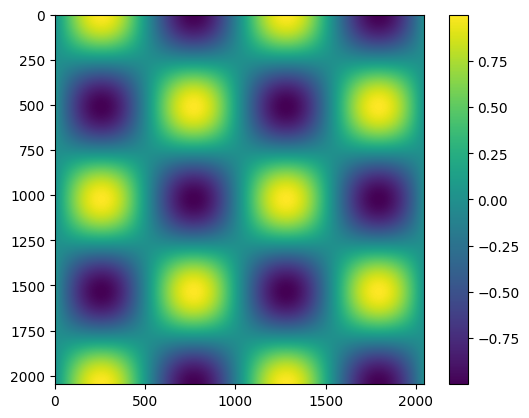

In [25]:
plt.imshow(img);plt.colorbar();

## Using JAX vmap

- one solution is using the meshgrid X,Y (2D arrays)
- one solution is using directly the 1D sampling arrays in x-axes and y-axes (no duplication of  sampling location information)

In [26]:
# if one has a non smart vectorized func: usage of vmap (1)
mapped = jax.vmap(func, in_axes=(0, 0))
img0 = jax.jit(mapped)(X,Y)
print(jnp.allclose(img,img0))
jax.debug.visualize_array_sharding(img0)

True


                         
                         
                         
                         
                         
          GPU 0          
                         
                         
                         
                         
                         

In [27]:
# vmap (2) using directly the xvals, yvals vectors
mapped = jax.vmap(jax.vmap(func, in_axes=(None, 0)), in_axes=(0, None))
img1 = jax.jit(mapped)(xvals,yvals)
print(jnp.allclose(img,img1))
jax.debug.visualize_array_sharding(img1)

False


                         
                         
                         
                         
                         
          GPU 0          
                         
                         
                         
                         
                         

### Using JAX multi-GPUs (TPUs)
(notice the "experimental" API)

- using the X,Y 2D meshgrid arrays

In [28]:
from jax.sharding import Mesh, NamedSharding,  PartitionSpec as P
from jax.experimental import mesh_utils
from jax.experimental.shard_map import shard_map

In [29]:
# The JAX API for multi-devices is changing over the time, so this is the way 21th May 2024 (v 0.4.26)
devices = mesh_utils.create_device_mesh((2, 2))  # 2D grid with our 4 GPUs
mesh = Mesh(devices, ('x', 'y'))
sharding = NamedSharding(mesh, P('x', 'y'))
print(sharding)

NamedSharding(mesh=Mesh('x': 2, 'y': 2), spec=PartitionSpec('x', 'y'))


In [30]:
shard_mapped = shard_map(func, mesh=mesh, in_specs=P('x','y'), out_specs=P('x','y'))
img2 = jax.jit(shard_mapped)(X,Y)
print(jnp.allclose(img,img2))
jax.debug.visualize_array_sharding(img2)

True


                        
                        
   GPU 0       GPU 1    
                        
                        
                        
                        
                        
   GPU 2       GPU 3    
                        
                        
                        

- using the 1D sampling arrays (reuse the nested vmap case)

In [31]:
mapped = jax.vmap(jax.vmap(func, in_axes=(None, 0)), in_axes=(0, None))
shard_mapped=shard_map(mapped, mesh=mesh, in_specs=(P('x'), P('y')), out_specs=P('x','y'))
img3 = jax.jit(shard_mapped)(xvals, yvals)
print(jnp.allclose(img,img3))
jax.debug.visualize_array_sharding(img3)

False


                        
                        
   GPU 0       GPU 1    
                        
                        
                        
                        
                        
   GPU 2       GPU 3    
                        
                        
                        

- using automatic sharding ! (probably the 1st thing to test)

In [32]:
x_sharded = jax.device_put(xvals, NamedSharding(mesh, P('x')))
jax.debug.visualize_array_sharding(x_sharded)

 GPU 0,1  GPU 2,3 
                  

In [33]:
y_sharded = jax.device_put(yvals, NamedSharding(mesh, P('y')))
jax.debug.visualize_array_sharding(y_sharded)

 GPU 0,2  GPU 1,3 
                  

In [34]:
mapped = jax.vmap(jax.vmap(func, in_axes=(None, 0)), in_axes=(0, None))
img4 = jax.jit(mapped)(x_sharded, y_sharded) # You let jit to perform th shard_mapping automatically
print(jnp.allclose(img,img4))
jax.debug.visualize_array_sharding(img4)

False


                        
                        
   GPU 0       GPU 1    
                        
                        
                        
                        
                        
   GPU 2       GPU 3    
                        
                        
                        

# The Julia set revisited

In [36]:
def julia(args_vars):
    
    cx,cy, XMIN, XMAX, YMIN, YMAX, LARGEUR, HAUTEUR, MAX_ITERATION = args_vars
     
    def func(ix,iy):
    
        def body(val):
            n,x,y = val
            xn = x * x - y * y + cx
            yn = 2 * x * y     + cy
            n = n+1
            return (n,xn,yn)

        cond_fun = lambda p : ((p[1]**2 + p[2]**2 < 4.) & (p[0] < MAX_ITERATION))

        x0 = (ix * (XMAX - XMIN) / LARGEUR + XMIN)
        y0 = (iy * (YMIN - YMAX) / HAUTEUR + YMAX)

        u = (0,x0,y0)
        u = jax.lax.while_loop(cond_fun,body,u)
        n = u[0]
        
        pixel_val = jax.lax.cond(jnp.isclose(n,MAX_ITERATION), 
                                 lambda _: 0., 
                                 lambda p: 0.222*((3*p)/256) + 0.666*(p/256) + 0.111*((10*p)/256),
                                operand=n)

        
        return pixel_val

    # single unit solution from JIT_fractals.ipynb
    # mapped = jit(vmap(vmap(func, in_axes=(None, 0)), in_axes=(0, None)))
    # result = mapped(jnp.arange(0, LARGEUR), jnp.arange(0, HAUTEUR))

    # 4 GPUs solution
    devices = mesh_utils.create_device_mesh((2, 2))  # 2D grid with our 4 GPUs
    mesh = Mesh(devices, ('x', 'y'))
    sharding = NamedSharding(mesh, P('x', 'y'))
    xvals = jnp.arange(0, LARGEUR)
    yvals = jnp.arange(0, HAUTEUR)
    x_sharded = jax.device_put(xvals, NamedSharding(mesh, P('x')))
    y_sharded = jax.device_put(yvals, NamedSharding(mesh, P('y')))
    mapped = jax.vmap(jax.vmap(func, in_axes=(None, 0)), in_axes=(0, None))
    result = jax.jit(mapped)(x_sharded, y_sharded) # You let jit to perform th shard_mapping automatically

    return result

In [42]:
def MatplotlibClearMemory():
    #usedbackend = matplotlib.get_backend()
    #matplotlib.use('Cairo')
    allfignums = mpl.pyplot.get_fignums()
    for i in allfignums:
        fig = mpl.pyplot.figure(i)
        fig.clear()
        mpl.pyplot.close( fig )
    #matplotlib.use(usedbackend) 

In [43]:
MatplotlibClearMemory()

In [46]:
XMIN, XMAX, YMIN, YMAX = -1.25, 1.25, -1.25, 1.25   # physical sapce
LARGEUR, HAUTEUR = 1024, 1024                         # image size
MAX_ITERATION = 150

HAUTEUR=LARGEUR=4096*4
cx, cy = 0.285, 0.01
args = (cx,cy, XMIN, XMAX, YMIN, YMAX, LARGEUR,HAUTEUR, MAX_ITERATION)
img = julia(args)

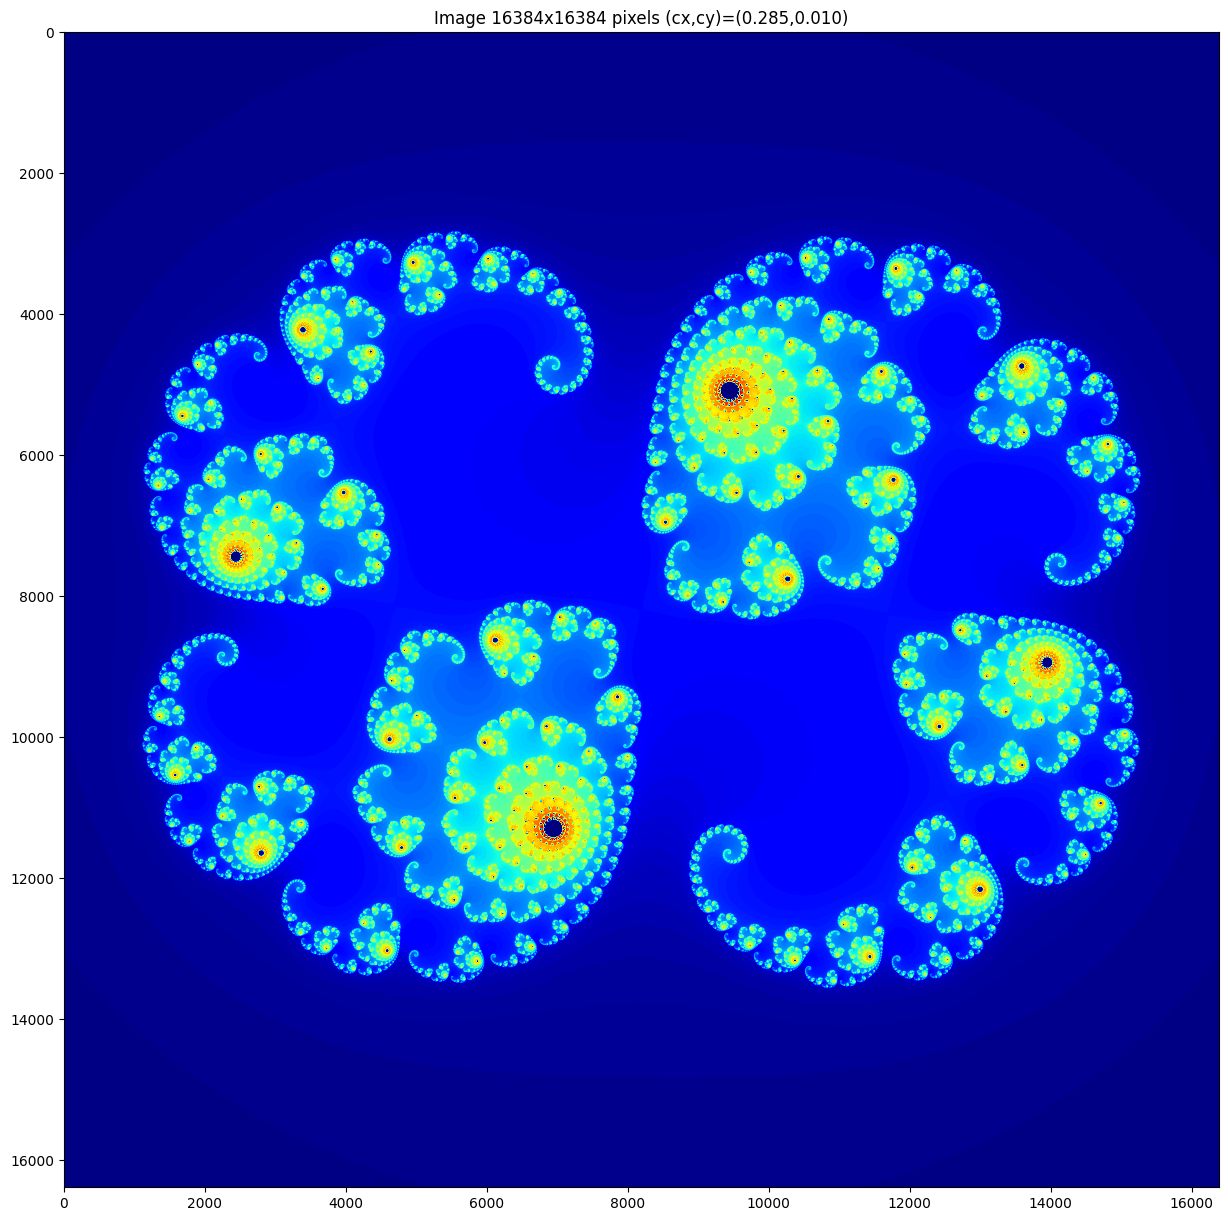

In [47]:
plt.figure(figsize=(15,15))
plt.imshow(img,cmap=mpl.cm.jet);
plt.title(fr"Image {HAUTEUR}x{LARGEUR} pixels (cx,cy)=({cx:.3f},{cy:.3f})");
plt.show()
MatplotlibClearMemory()